In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.pardir)))

In [2]:
from src.data_loader import load_s1_mat

file_path = '../data/raw/S1.mat'
eeg_trials, attended_labels, fs = load_s1_mat(file_path)

print(f"Number of trials: {len(eeg_trials)}")
print(f"Sampling rate: {fs} Hz")
print(f"Shape of first trial EEG: {eeg_trials[0].shape} (samples × channels)")
print(f"First 5 attended labels: {attended_labels[:5]}")


Number of trials: 20
Sampling rate: 128 Hz
Shape of first trial EEG: (49792, 64) (samples × channels)
First 5 attended labels: ['R', 'L', 'R', 'L', 'R']


In [3]:
from src.preprocess import preprocess_eeg_trials
from src.data_loader import load_s1_mat

file_path = '../data/raw/S1.mat'
eeg_trials, attended_labels, fs = load_s1_mat(file_path)

print(f"Original sampling rate: {fs} Hz")
print(f"Number of trials before preprocessing: {len(eeg_trials)}")

# Example preprocessing: filter 1-40 Hz, downsample to 128 Hz
processed_trials, new_fs = preprocess_eeg_trials(eeg_trials, sfreq=fs, l_freq=1, h_freq=40, downsample=128)

print(f"New sampling rate after downsampling: {new_fs} Hz")
print(f"Shape of first processed trial: {processed_trials[0].shape} (channels x samples)")


Original sampling rate: 128 Hz
Number of trials before preprocessing: 20
Creating RawArray with float64 data, n_channels=64, n_times=49792
    Range : 0 ... 49791 =      0.000 ...   388.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=50048
    Range : 0 ... 50047 =      0.000 ...   390.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=49792
    Range : 0 ... 49791 =      0.000 ...   388.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=51072
    Range : 0 ... 51071 =      0.000 ...   398.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=49792
    Range : 0 ... 49791 =      0.000 ...   388.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=50048
    Range : 0 ... 50047 =      0.000 ...   390.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=49792
    Range : 0 ... 49791 =      0.000 ...   388.992 secs
Ready.
Creating RawArray with f

In [4]:
from src.dataset import segment_trials, EEGAttentionDataset
from torch.utils.data import DataLoader

# Segment trials into fixed-length windows (e.g., 2 sec = 256 samples at 128Hz)
segment_length = 256
segmented_trials = segment_trials(processed_trials, segment_length=segment_length, overlap=0)

# Expand labels for each segment
segmented_labels = []
for label, trial in zip(attended_labels, processed_trials):
    n_segments = (trial.shape[1] - segment_length) // segment_length + 1
    segmented_labels.extend([label] * n_segments)

# Create Dataset and DataLoader
dataset = EEGAttentionDataset(segmented_trials, segmented_labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Check batch shapes
for batch_eeg, batch_labels in dataloader:
    print(batch_eeg.shape)  # (batch_size, channels, samples)
    print(batch_labels)
    break

torch.Size([16, 64, 256])
tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0])


In [5]:
import torch
from src.dataset import EEGAttentionDataset, segment_trials
from src.data_loader import load_s1_mat
from src.model import CNNLSTMAttentionDecoder

# Instantiate the model
model = CNNLSTMAttentionDecoder(n_channels=64, segment_length=segment_length)
print(model)

# Example forward pass with one batch
for batch_eeg, batch_labels in dataloader:
    outputs = model(batch_eeg)  # batch_eeg shape: (B, 64, 256)
    print(outputs.shape)  # (B, 2)
    break


CNNLSTMAttentionDecoder(
  (conv1): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)
torch.Size([16, 2])


In [6]:
from src.train import train_model

trained_model = train_model(
    file_path='../data/raw/S1.mat',
    batch_size=16,
    num_epochs=10,
    learning_rate=1e-3,
    segment_length=256,
    val_ratio=0.2,
    device=None,  # auto-select GPU if available
    save_path='best_model.pth'
)


Using device: cpu
Loading data...
Loaded 20 trials at 128 Hz
Preprocessing EEG...
Creating RawArray with float64 data, n_channels=64, n_times=49792
    Range : 0 ... 49791 =      0.000 ...   388.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=50048
    Range : 0 ... 50047 =      0.000 ...   390.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=49792
    Range : 0 ... 49791 =      0.000 ...   388.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=51072
    Range : 0 ... 51071 =      0.000 ...   398.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=49792
    Range : 0 ... 49791 =      0.000 ...   388.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=50048
    Range : 0 ... 50047 =      0.000 ...   390.992 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=49792
    Range : 0 ... 49791 =      0.000 ...   388.992 secs
Ready.
Creating RawArr

In [10]:
from src.inference import load_trained_model, predict_segments
from torch.utils.data import random_split

# Suppose you have (or want to use a held-out or test set of) EEG segments
# For demonstration, we'll use the first 10 segments from your validation split:

val_ratio = 0.2  # 20% for validation
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

_, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
val_segments = [val_dataset[i][0].cpu().numpy() for i in range(10)]  # shape (channels, segment_length)

# Load the trained model (provide proper segment_length if changed)
model = load_trained_model('best_model.pth', n_channels=64, segment_length=256)

preds, probs = predict_segments(model, val_segments)

for i, (pred, prob) in enumerate(zip(preds, probs)):
    print(f"Segment {i}: Predicted = {'R' if pred==1 else 'L'}, Probabilities: L={prob[0]:.2f}, R={prob[1]:.2f}")


Segment 0: Predicted = L, Probabilities: L=0.79, R=0.21
Segment 1: Predicted = R, Probabilities: L=0.30, R=0.70
Segment 2: Predicted = L, Probabilities: L=0.77, R=0.23
Segment 3: Predicted = R, Probabilities: L=0.45, R=0.55
Segment 4: Predicted = R, Probabilities: L=0.42, R=0.58
Segment 5: Predicted = L, Probabilities: L=0.68, R=0.32
Segment 6: Predicted = R, Probabilities: L=0.45, R=0.55
Segment 7: Predicted = L, Probabilities: L=0.77, R=0.23
Segment 8: Predicted = R, Probabilities: L=0.39, R=0.61
Segment 9: Predicted = L, Probabilities: L=0.61, R=0.39


In [12]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import torch
from src.inference import load_trained_model
from torch.utils.data import DataLoader

# Suppose you have your EEGAttentionDataset and val_dataset ready as before
# Example: (If using previous split)
# val_dataset = ... (from your validation split)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load trained model
model = load_trained_model('best_model.pth', n_channels=64, segment_length=256)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for eeg_batch, label_batch in val_loader:
        eeg_batch = eeg_batch.to(device)
        logits = model(eeg_batch)
        preds = logits.argmax(dim=1).cpu().numpy()      # 0='L', 1='R'
        all_preds.extend(preds)
        all_true.extend(label_batch.numpy())

# Calculate accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

acc = accuracy_score(all_true, all_preds)
mat = confusion_matrix(all_true, all_preds)
report = classification_report(all_true, all_preds, target_names=['L', 'R'])

print(f"Validation accuracy: {acc:.4f}")
print("Confusion matrix:")
print(mat)
print("Classification report:")
print(report)


Validation accuracy: 0.7158
Confusion matrix:
[[165  64]
 [ 67 165]]
Classification report:
              precision    recall  f1-score   support

           L       0.71      0.72      0.72       229
           R       0.72      0.71      0.72       232

    accuracy                           0.72       461
   macro avg       0.72      0.72      0.72       461
weighted avg       0.72      0.72      0.72       461



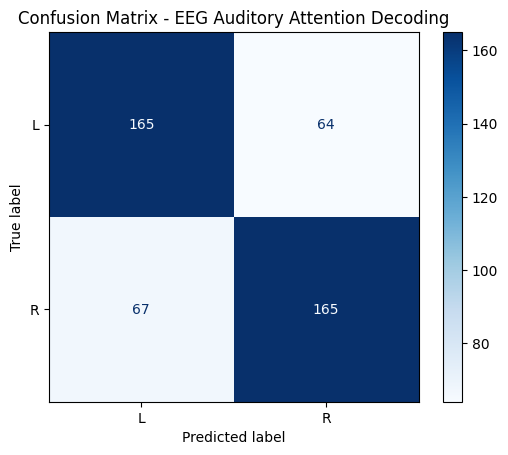

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have:
# all_true: list or np.array of true labels (as integers 0 for 'L', 1 for 'R')
# all_preds: list or np.array of predicted labels (0 or 1)

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['L', 'R'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - EEG Auditory Attention Decoding")
plt.show()


In [19]:
import torch
from torch.utils.data import DataLoader
from src.inference import load_trained_model

# Assuming val_dataset is already defined (your validation split)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_trained_model('best_model.pth', n_channels=64, segment_length=256, device=device)

all_true = []
all_preds = []
all_probs = []

model.eval()
with torch.no_grad():
    for eeg_batch, label_batch in val_loader:
        eeg_batch = eeg_batch.to(device)
        label_batch = label_batch.to(device)

        logits = model(eeg_batch)               # logits shape (batch, 2)
        probs = torch.softmax(logits, dim=1)   # softmax probabilities
        
        preds = torch.argmax(probs, dim=1)

        all_true.extend(label_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # probabilities for both classes

# Now all_probs is a list of [P(L), P(R)] arrays
# To compute ROC curve, we use the probability for class 'R' (index 1)


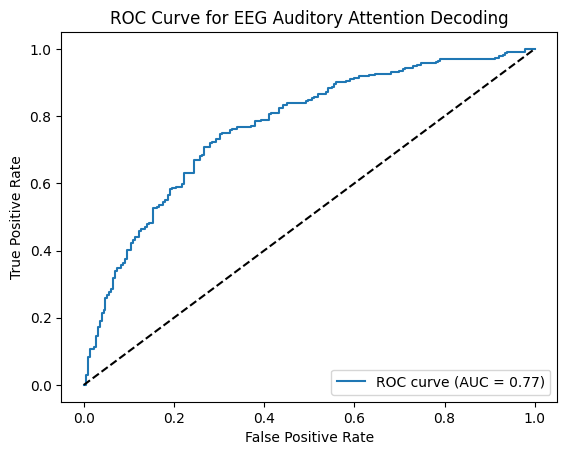

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Extract probability of the positive class 'R' = 1
y_true = all_true
y_scores = [p[1] for p in all_probs]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for EEG Auditory Attention Decoding")
plt.legend(loc="lower right")
plt.show()
